# Photometry with Python

In this lecture note, I will use a data from [Ishigakijima Astrophysical Observatory](https://en.wikipedia.org/wiki/Indian_Astronomical_Observatory) telescope.

** It has already been preprocessed and WCS implemented **

Things we will learn (numbers here are not equal to the section numbers):
1. How to deal with MEF (Multi Extension [FITS](https://fits.gsfc.nasa.gov/)) file in the format of HDU (Header Data Unit)
  * I will assume you know what FITS is.
  * Detailed explanation can be found at [this astropy document](http://docs.astropy.org/en/stable/io/fits/)
  * Simply put, *FITS = image data format used in astronomical society*.
2. Split one extension of FITS file
3. Crop the image by centering the comet while conserving the WCS (World Coordinate System) information
  * I will assume you know what WCS is.
  * Detailed explanation can be found at [this astropy document](http://docs.astropy.org/en/stable/wcs/index.html)
  * Simply put, *WCS = information or parameters which allows you to convert the image x y coordinate to real coordinate, such as RA and DEC*.
4. Find UCAC4 stars which are within the FOV
  * UCAC4 information: [USNO](http://www.usno.navy.mil/USNO/astrometry/optical-IR-prod/ucac)
  * Find "UCAC4" at [VizieR](http://vizier.u-strasbg.fr/viz-bin/VizieR) and look what each column means
5. Do aperture photometry to get the instrumental magnitude of the stars.
6. Find a comet which is known to be within the FOV
7. Do aperture photometry to get the instrumental magnitude of the comet as a function of radius.

I will try **NOT** to explain too much detailed technical issues, such as "what does ``hdul[0].header`` mean?". Please find the answers by yourselves at the linked reference websites! You will learn a lot from there!

Before going into the procedures, let be briefly introduce ``astropy.io.fits`` module, and ``astroquery.jplhorizons`` module.

## 1. Introducing Modules

### 1.1. Using FITS in Python: `astropy.io.fits`

In astropy, one of the most important modules is `fits`, which is used for manipulating FITS file. As of Astropy 2.0, the ``CCDData`` class has implemented to ``astropy.nddata`` (previously it was in ``ccdproc`` package).

The ``ccdproc.CCDData`` may be deprecated soon by [issue #510](https://github.com/astropy/ccdproc/issues/510).

### 1.2. Ephemerides of Non-Sidereal Targets: ``astroquery.jplhorizons``
The [JPL HORIZONS](https://ssd.jpl.nasa.gov/horizons.cgi) service is very famous one among people who are observing planets, asteroids and/or comets. Because these do not have fixed position on the sky (RA/DEC, alt/az, l/b, etc), their position values must be calculated by professional softwares so that we can find where the target must be at. This kind of information is called [**ephemeris (plural: ephemerides)**](https://en.wikipedia.org/wiki/Ephemeris). The targets that move relative to stars over time, especially solar system objects, are together called *non-sidereal objects*.

To get an ephemeris of an object, we need (1) **observatory location**, (2) **observation time**, and (3) the **target object name**. For example, if you want the AltAz information of Jupiter at Seoul on 2018-01-01 08:00:00, you need these three information.

For the first item, the observatory location, we customarily use the so-called **observatory code**. Each observatory has its own code, e.g., ``'D44'`` for IAO (you may use [this wiki page](https://en.wikipedia.org/wiki/List_of_observatory_codes)). You always have to know the observatory code to correctly query the ephemerides of targets. If you don't have one, select any observatory that is near you, or you may set the observatory's lon/lat/height manually.


To install [astroquery](http://astroquery.readthedocs.io/en/latest/index.html), you can use ``conda`` command. 


> But as of 2018 April, ``jplhorizons`` is **not** included in the stable version (0.3.7), so you need the development version by:
>
> ```
> git clone https://github.com/astropy/astroquery.git
> cd astroquery
> python setup.py install
> ```
>
> on the terminal. If you cannot understand it, please take a look at the Git/GitHub section of the software installation lecture note. In the near future when ``jplhorizons`` is included in the stable version, you may simply do
>
> ```
> conda install -c astropy astroquery
> ```

## 2. Extract One Extension from MEF

Sometimes people want to store more than just one CCD image. For example, you can have a 100 by 100 pixel image, and 100 by 100 pixel flag map (e.g., whether the ``(i, j)`` pixel is a bad pixel), you may want to combine those two images into one single file. That led FITS community to introduce a standard way to include many CCD image frames into one single FITS file. This is called the **Multi-Extension FITS (MEF)** file. Each frame is called an extension and all such extensions share the same primary header. Each extension may have some differences from other extensions, so they have their own extension header, too. See the following figure from here:

Honestly speaking, this MEF format causes a lot of headache especially to beginners. Especially for some of the cases, I cannot agree with the idea of using MEF; it makes everything more complicated and bothersome :(... 

So in this section, I will separate only one of the 3 extensions from the tutorial FITS and save only that extension as a new FITS file. The three extensions are ``Primary``, ``SCI``, and ``DUMMY``. Except for ``SCI`` are made by myself for this tutorial. ``Primary`` contains all the necessary header information but not image, ``SCI`` contains all the scientific image data but not informative header, and ``DUMMY`` is just a dummy header with dummy image data.

One thing to consider is that, as I said, each extension has its own extension header, but some part of its information is stored in the primary header...!! So we need to consider the primary header as well:

In [1]:
from pathlib import Path
from astropy.io import fits

# =============================================================================
# A. Set the path to the file in an OS-independant way
# =============================================================================
f_original = Path('Photometry', 'MEF_Tutorial_41P.fits')

# =============================================================================
# B. Load FITS file
# =============================================================================
hdul = fits.open(f_original)

# =============================================================================
# C. Select only the 4th extension and save it.
# =============================================================================

# C.1. For future information, I added one header keyword which saves the 
#      original FITS filename
hdul[0].header['FITSNAME'] = f_original.name

# C.2. Make a new HDUList which contains the data & headers (primary header
#      and the extension header)
newhdul = fits.HDUList([fits.PrimaryHDU(data = hdul['SCI'].data,
                                        header = hdul[0].header + hdul['SCI'].header)])

# C.3. Wirte the FITS file
newhdul.writeto(Path('Photometry', 'MEF_SCI.fits'), overwrite=True)

# If you want to remove the original FITS file, do the following:
# f_original.unlink()

I opened the FITS file with ``fits.open`` and accessed to the header of a HDUList object. For detailed explanation, please look around [the astropy documentation](http://docs.astropy.org/en/stable/io/fits/index.html).

The last line, ``f_oritinal.unlink()`` will delete the original FITS file to save your storage! Do this with care, because you may lose the data forever.

* **Homework**: Try the below code block and think about what the code lines mean
* **Homework**: On the terminal, type ``fitsinfo MEF_Tutorial_41P.fits``, ``fitsheader MEF_Tutorial_41P.fits[0]`` and compare the results from the following code block's result.
* **Homework**: On the terminal, type ``ds9 MEF_Tutorial_41P.fits[2] &``. Confirm that this image is different from ``ds9 MEF_Tutorial_41P.fits &``. The rectangular bracket ``[i]`` shows the i-th extension data. If not given, ds9 shows the very first extension which contains data.
* **Homework**: Open the resulting file by ``ds9 MEF_SCI.fits`` and look at the bottom of the header, and check whether ``FITSNAME`` keyword is inserted as expected.

In [2]:
print(type(hdul), end='\n\n')
hdul.info()
print()
print(hdul[1].data, end='\n\n')
print(list(hdul[0].header.keys()), end='\n\n')
print(hdul[0].header['DATE-OBS'])

# Close the HDU
hdul.close()

<class 'astropy.io.fits.hdu.hdulist.HDUList'>

Filename: Photometry/MEF_Tutorial_41P.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     109   ()      
  1  SCI           1 ImageHDU         8   (1024, 1024)   float32   
  2  DUMMY         1 ImageHDU         8   (1024, 1024)   float64   

[[247.53215 171.57141 186.25075 ... 161.94635 217.60677 187.98471]
 [148.17743 134.4331  161.24011 ... 158.27179 175.1796  156.70593]
 [156.30624 172.98788 158.88438 ... 156.54163 135.87886 137.07417]
 ...
 [157.28262 146.39754 177.648   ... 172.55215 166.09161 138.90361]
 [185.16881 166.8418  176.84682 ... 162.46475 168.05496 148.91057]
 [143.10759 159.01254 179.45273 ... 167.1202  139.2142  148.1094 ]]

['SIMPLE', 'BITPIX', 'NAXIS', 'EXTEND', 'ORIGIN', 'DATE', 'IRAF-TLM', 'COMMENT', 'COMMENT', 'DATA-TYP', 'OBJECT', 'FILTER', 'OBSERVAT', 'TELESCOP', 'FOC-POS', 'DETECTOR', 'CAM-ID', 'CREATOR', 'LATITUDE', 'LONGITUD', 'HEIGHT', 'DATE-OBS', 'UT', 'JST', 

## 3. Crop the Image

OK! Now we have an image of about 4 MB size (1024 by 1024 pixels). This is where we usually start our science. Normally we don't get MEF without specific purposes (Hubble Space Telescope provides MEF but it has clear reasons).

* HOMEWORK: Is the following result as expected?

In [3]:
import numpy as np
print(newhdul[0].data.shape)

(1024, 1024)


I let you extract only the SCI extension because there is a comet named [41P/Tuttle–Giacobini–Kresák](https://en.wikipedia.org/wiki/41P/Tuttle%E2%80%93Giacobini%E2%80%93Kres%C3%A1k). Although the image size is appropriate now (only about 1 M pixel), it is often the case that the image is much larger than enough (e.g., one image will be as large as 1 GB for some data). Say you want to crop the image with 1000 by 1000 pixel size with the comet at the center. To do so, my plan is

1. Query to jplhorizons module and get the comet's location in RA/DEC at the time of the observation.
2. Convert that RA/DEC position to image XY
3. Crop the image and save it with appropriate WCS information.

To do so, I will use 
* [``astropy.time.Time``](http://docs.astropy.org/en/stable/time/index.html) with ``astropy.units``
* [``astropy.coordinates.SkyCoord``](http://docs.astropy.org/en/stable/coordinates/index.html)
* [``astropy.wcs.WCS``](http://docs.astropy.org/en/stable/wcs/index.html)

In [4]:
import astroquery
print(astroquery.__version__)

0.3.8.dev4445


In [5]:
# =============================================================================
# D. Find where the comet is
# =============================================================================

from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astroquery.jplhorizons import Horizons

def get_obs_code(observatory):
    ''' Get the observatory code.
    '''
    if observatory.lower() == 'iao':
        return 'D44'
    elif observatory.lower() == 'oao':
        return 371
    else:
        raise ValueError("Observatory must be one of IAO and OAO.")

# D.1. Find the observatory name from the header and convert it to code
new_hdr = newhdul[0].header
observatory = new_hdr['OBSERVAT'].split('/')[0]
observatory_code = get_obs_code(observatory)

# D.2. Find the observation time and exposure time to set the obs time
t_start = Time('{}T{}'.format(new_hdr['DATE-OBS'], new_hdr['UT']) , format='isot')
t_expos = new_hdr['EXPTIME'] * u.s
t_middle = t_start + t_expos / 2 # start time + 0.5 * exposure time

# D.3. Query the ephemerides of this target! See below why I used '900486', not '41P'.
obj = Horizons(id='900486', location=observatory_code, epochs=t_middle.jd)
obj_ephem = obj.ephemerides()

# D.4. Get the WCS information and convert it to image XY coordinate
w = WCS(new_hdr)
obj_radec = SkyCoord(obj_ephem['RA'][0], obj_ephem['DEC'][0], unit=u.deg)
obj_imgxy = obj_radec.to_pixel(wcs=w)
cut = Cutout2D(newhdul[0].data, obj_imgxy, (1000, 1000), wcs=w)

# D.5. Save the cutout image with correctly updated WCS information
cut_hdu = fits.PrimaryHDU(data = cut.data,
                          header = new_hdr + cut.wcs.to_header())
cut_hdu.writeto(Path('Photometry', "MEF_SCI_cut.fits"), overwrite=True)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Now let's display the image:

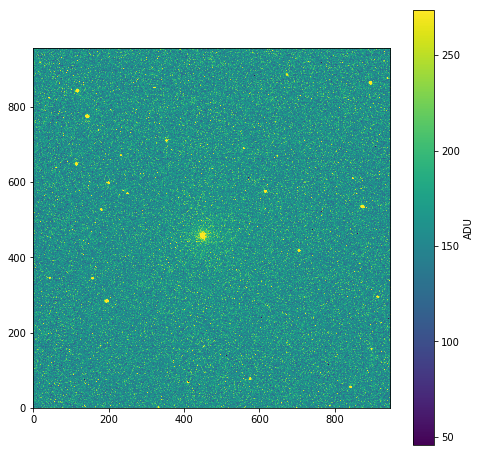

Image size is:  (957, 948)


In [7]:
# =============================================================================
# E. Plot cutout image
# =============================================================================

from matplotlib import pyplot as plt
from astropy.visualization import ZScaleInterval, ImageNormalize

def znorm(image, **kwargs):
    return ImageNormalize(image, interval=ZScaleInterval(**kwargs))

def zimshow(ax, image, **kwargs):
    return ax.imshow(image, norm=znorm(image, **kwargs), origin='lower')

fig, ax = plt.subplots(1,1, figsize=(8,8))
c = zimshow(ax, cut_hdu.data)
plt.colorbar(c, label="ADU")
plt.show()
print("Image size is: ", cut_hdu.data.shape)

* **HOMEWORK**: One thing to note is that the final image size is **NOT** 1000 by 1000! Why do you think so?

### 3.1. Notes when Querying Comets
In the code, I used ``id='900486'`` rather than ``'41P'``. If you use ``'41P'``, You'll have the following error:

```python
# Error will be generated
obj = Horizons(id='41P', location=observatory_code, epochs=t_middle.jd)
obj_ephem = obj.ephemerides()
```
```
ValueError: Ambiguous target name; provide unique id:
    Record #  Epoch-yr  >MATCH DESIG<  Primary Desig  Name  
    --------  --------  -------------  -------------  -------------------------
      900475    1858    41P            41P             Tuttle-Giacobini-Kresak
      900476    1907    41P            41P             Tuttle-Giacobini-Kresak
      900477    1951    41P            41P             Tuttle-Giacobini-Kresak
      900478    1962    41P            41P             Tuttle-Giacobini-Kresak
      900479    1973    41P            41P             Tuttle-Giacobini-Kresak
      900480    1979    41P            41P             Tuttle-Giacobini-Kresak
      900481    1990    41P            41P             Tuttle-Giacobini-Kresak
      900482    1995    41P            41P             Tuttle-Giacobini-Kresak
      900483    2001    41P            41P             Tuttle-Giacobini-Kresak
      900484    2006    41P            41P             Tuttle-Giacobini-Kresak
      900485    2008    41P            41P             Tuttle-Giacobini-Kresak
      900486    2017    41P            41P             Tuttle-Giacobini-Kresak
```
It is because comets' orbits can change when they get closer to the Sun due to the *non-Newtonian force*, e.g., gas ejection from the cometary surface, etc. So the orbital elements of the comet will change over time even thouth we are concerning the identical comet. The code I used is the orbital elements calculated based on 2017, as can be seen from the error message (*error message is very informative indeed!*)

* **HOMEWORK**: Try ``id='900475'`` and see how different it is.

## 4. Finding Catalog Stars

It is always very important to find stars in the FOV that have known magnitude and astrometric information. That will enable us to do differential photometry, and if we are sure that the stars are non-variable stars, we may be able to do absolute photometry for sidereal objects.

In this section, I will

1. Query stars from a catalog (I will use UCAC4)
2. Select stars with reasonable magnitude range (from the FITS image, you must manually find this range by looking at S/N ratio and saturation)
   * I chose the range as g = 13.5-17 mag since the image is taken in g band (see ``new_hdr['FILTER']``)
3. Overplot the locations of the stars on the image for visualization (red circles)
4. Using star-finding algorithms, overplot the star candidates (black circles).

I will use [``photutils.CircularAperture``](https://photutils.readthedocs.io/en/stable/aperture.html), [``astropy.stats.sigma_clipped_stats``](http://docs.astropy.org/en/stable/stats/index.html), and the star finding algorithm from DAO: [``photutils.DAOStarFinder``](https://photutils.readthedocs.io/en/stable/detection.html).

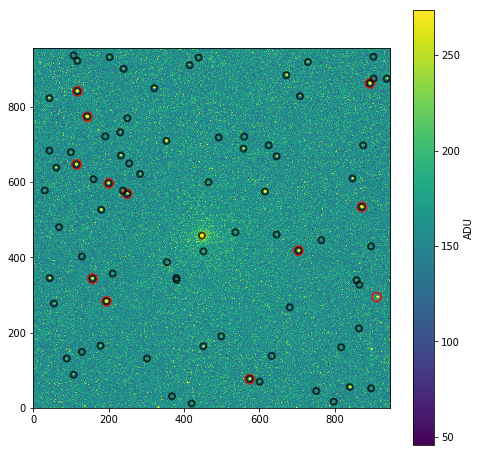

In [8]:
# =============================================================================
# F. Query UCAC4 stars
# =============================================================================
import numpy as np
from astroquery.vizier import Vizier
from photutils import CircularAperture as CircAp
from photutils import DAOStarFinder
from astropy.stats import sigma_clipped_stats

# F.1. Set some variables
w_cut = cut.wcs
obs_filter = new_hdr['FILTER'].lower()
m_min = 13.5
m_max = 17

# F.2. Set the column names to query and corresponding filters
columns = ['RAJ2000', 'DEJ2000', 'Nu', f'{obs_filter}mag', f'e_{obs_filter}mag']

column_filters = {'Nu': '>2',  # # of observations used for the cataloging
                  f'{obs_filter}mag': f'{m_min} .. {m_max}', # magnitude range
                  f'e_{obs_filter}mag': '0 .. 15'}           # mag err range in 0.01 mag

viz = Vizier(columns=columns, column_filters=column_filters)
viz.ROW_LIMIT = -1 # by default, only up to 50 rows are returned.

# F.3. Query!
UCAC4 = viz.query_region(obj_radec, radius = 0.15 * u.deg, catalog=['UCAC4'])[0]

# F.4. Convert the result to CircularAperture object
coords_UCAC4 = SkyCoord(UCAC4['RAJ2000'], UCAC4['DEJ2000']).to_pixel(w_cut)
apertures_UCAC4 = CircAp(coords_UCAC4, r=12)

# F.5. Run star finding algorithm
avg, med, std = sigma_clipped_stats(cut_hdu.data) # default is 3-sigma, 5 iters
thresh = 5 * std
finder = DAOStarFinder(fwhm=3, threshold=thresh, # In reality, FWHM must be measured a priori using ``ginga``
                      sharplo=0.2, sharphi=1.0,  # default values 0.2 and 1.0
                      roundlo=-1.0, roundhi=1.0, # default values -1 and +1
                      sigma_radius=1.5,          # default values 1.5
                      ratio=1.0,                 # 1.0: circular gaussian
                      exclude_border=True)       # To exclude sources near edges

# The DAOStarFinder object ``finder`` gets at least one input: the image.
# Then it returns the astropy table which contains the aperture photometry results:
found = finder(cut_hdu.data)

# Use ``found`` for aperture photometry:
coords_SF = (found['xcentroid'], found['ycentroid'])
apertures_SF = CircAp(coords_SF, r=8.)  

# F.6. Plot all
fig, ax = plt.subplots(1,1, figsize=(8,8))
c = zimshow(ax, cut_hdu.data)
apertures_UCAC4.plot(color='red', lw=2, alpha=0.7)
apertures_SF.plot(color='k', lw=2, alpha=0.7)
plt.colorbar(c, label="ADU")
plt.show()


* **HOMEWORK**: Try ``print(viz.query_region(obj_radec, radius = 0.2 * u.deg, catalog=['UCAC4']))`` and think why I put ``[0]`` at the end of it, which is identical to do ``result = viz.query_region(obj_radec, radius = 0.2 * u.deg, catalog=['UCAC4'])['I/322A/out']``.
* **HOMEWORK**: Change ``roundlo=-1.0, roundhi=1.0,`` to ``roundlo=-1.5, roundhi=1.5,``, then check whether the one star at the middle right which has only red circle now has black circle too. This happens since the observation was made in non-sidereal tracking mode, i.e., the stars become slightly elliptical on the CCD. I didn't tune these values here since I wanted to show you how such stars are rejected in the next section.
* **HOMEWORK**: I used ``radius = 0.15 * u.rad``, which is so-called *hard-coding*. How do you think this can be more generally coded?
  * Hint: Think about ``w_ends = w_cut.wcs_pix2world([[1, 1], [*cut_hdu.data.shape]], 0)`` and then ``radius = np.sqrt(np.sum((w_ends[0] - w_ends[1])**2)) / 2 * u.rad``. 

## 5. Matching Catalog and Found Stars

We have one more thing before going further. The catalog star positions calculated based on WCS (the red circles) are slightly different from the centroids found by the star-finding algorithm used on the real CCD data. This is important, since we cannot do the photometry centered at wrong position!

In this section, I will

1. Set the maximum match distance 
   * If the catalog position and star finder position differs more than this, discard that star.
   * The star might have been elongated too much, saturated so that it has highly non-circular shape, too faint due to certain reasons, ...
2. For all the stars found from the catalog, calculate the distances with all the stars found from the star finding algorithm.
   * This part should be done smartly. If you just use a lot of for loops, calculation time will grow and the code will look ugly. Think as vectorized way as possible!
   * Usually #(catalog stars) < #(star-finder stars), so it is better to put catalog stars in the ``for`` loop, and use vectorized calculation for the calculations which require #(star-finder stars)-order of times.
3. Save only the successfully matched stars with 
   1. Catalog-estimated XY coordinates
   2. The centroid position from star-finder algorithm
   3. The pixel shift, i.e., distance, between the above two.
      * If this shift is much larger than 1 pixel, e.g., 3 pixel, we must re-check the WCS, CCD image (such as cosmic ray), etc.

In [9]:
#%%timeit
# ^ This is "IPython magic", not a real code line.

# =============================================================================
# G. Catalog and StarFinder Matching
# =============================================================================

# G.1. Set the maximum allowable distance
match_distance = 5 # pixel

# G.2. Initialize some columns
UCAC4["x"] = coords_UCAC4[0]
UCAC4["y"] = coords_UCAC4[1]
UCAC4["xcentroid"] = 0.
UCAC4["ycentroid"] = 0.
UCAC4["peak"] = 0.
UCAC4["pixel_shift"] = match_distance + 1.

# G.3. Iterate over the catalog stars
for i, coo in enumerate(UCAC4):
    dx = np.abs(found['xcentroid'] - coo['x'])
    dy = np.abs(found['ycentroid'] - coo['y'])
    distances = np.sqrt(dx**2 + dy**2)
    accepted_SF = found[distances < match_distance]
    if len(accepted_SF) == 0:
        continue
    else:
        UCAC4[i]["pixel_shift"] = distances.min()
        UCAC4[i]["xcentroid"] = found[distances.argmin()]["xcentroid"]
        UCAC4[i]["ycentroid"] = found[distances.argmin()]["ycentroid"]
        UCAC4[i]["peak"] = found[distances.argmin()]["peak"]

# G.5. Select only those which are matched
UCAC4_matched = UCAC4[UCAC4["pixel_shift"] < match_distance]

In [10]:
# G.6. Print pretty table (just for fun!)
for c in UCAC4_matched.colnames[-5:]:
    UCAC4_matched[c].format="%9.4f"
    
UCAC4_matched.pprint(max_width=100)

  RAJ2000     DEJ2000    Nu  gmag  e_gmag ...     y     xcentroid ycentroid    peak    pixel_shift
    deg         deg          mag    cmag  ...                                                     
----------- ----------- --- ------ ------ ... --------- --------- --------- ---------- -----------
143.6586836  17.5545753   3 13.655     09 ...  533.3407  871.8255  533.4238  9482.3848      0.4754
143.6947765  17.5321067   3 15.244     10 ...  417.5986  703.9662  417.5301  2220.3752      0.0688
143.7238306  17.4641459   3 15.702     08 ...   76.4898  574.3062   77.0819  1464.5144      0.6276
143.7900368  17.5645934   3 16.400     01 ...  568.6230  249.3433  568.4589   859.6160      0.2301
143.8001836  17.5703467   3 15.731     12 ...  596.1232  200.1286  596.4452  1556.6492      0.4867
143.8029533  17.5074225   6 13.647     09 ...  282.9755  194.2731  283.2916 10933.5996      0.3441
143.8105271  17.5196806   3 15.599     10 ...  343.0982  157.1633  343.3239  1770.2944      0.2258
143.817963

From the ``timeit`` magic I could get ~ 40 ms for this calculation.

* **HOMEWORK**: Wait, it seems like the ``'x'`` of the first row, which must be ``872.2936218238`` is now rounded off! Is this information lost? Check by returning to higher accuracy format, e.g., ``UCAC4_matched["x"].format="%.10f"`` and reprint the table by ``UCAC4_matched["x"]``. You can see the values are restored. ``.format`` just changes how it is printed out, not the internal value.

Plus, as you can see, only 11 stars are "matched" among 12 stars in the catalog (count the number of red circles in the previous figure). As mentioned the star at the middle right is a bit too elongated, so the ``roundlo=-1.0, roundhi=+1.0`` condition failed to detect that as a star. We lost one star, but let's get our fingers crossed for the next step..!

## 6. Instrumental Magnitude

Phew! Such a long way. ~~TA is also getting a bit tired at this moment...~~

Now I want to do the photometry on stars to find the instrumental magnitude and its error.

I must do

1. Estimate FWHM of stars more precisely
   * Mostly people don't do this seriously, but for educational purpose I put a code snippet which automatically estimates the Gaussian FWHM of stars.
2. Set the aperture radius and annulus regions for all the matched stars.
   * Rule of thumb is ``r_ap = 1.5 * FWHM`` since then ``r_ap`` becomes nearly 3-sigma level.
   * Also for annulus, ``r_in, r_out = 4 * FWHM, 6 * FWHM`` are usually taken. The factors can change depending on the crowdedness of the field.
3. Do the aperture summation within the aperture (partial pixel sum by ``'exact'`` mode).
4. Do the sky estimation within the annulus (no partial, but ``'center'`` mode should be used)
   * Sky estimation has many ways. This time, I will just give you a function.
5. Get the instrumental magnitude and its error
   * $m_{\rm inst} := -2.5 \log_{10} (N / t_{\rm exp})$
   * $\Delta m_{\rm inst} = 1.086 \frac{\Delta N}{N}$ 
   * $\Delta N = \sqrt{ \frac{N}{g} + n_a \left (\frac{m_s}{g} + \left ( \frac{R}{g} \right )^2 \right) + \frac{n_a^2 s_s^2}{n_s}} = \sqrt{ \frac{N_{\rm tot}}{g} + n_a \left ( \frac{R}{g} \right )^2 + \frac{n_a^2 s_s^2}{n_s}} ~.$
   * Here,
     * $N$ is the source only count in ADU
     * $N_{\rm tot}$ is the total pixel value in ADU (you may include dark current here)
     * $g$ and $R$ are gain (e/ADU) and read out noise (electron unit).
     * $n_a$ is the number of pixel in aperture ($\pi r_a^2$ for circular aperture)
     * $n_s$ is the number of pixels used to estimate sky (mostly integer)
     * $s_s$ is the sample standard deviation of the sky pixels after sigma-clipping.

In [74]:
# =============================================================================
# H. Aperture Photometry and Instrumental Magnitudes
# =============================================================================

# H.1. Define some useful functions
import warnings

import numpy as np
from astropy.stats import sigma_clip
from astropy.nddata import CCDData
from astropy.table import Table, hstack

def sky_fit(all_sky, method='mode', sky_nsigma=3, sky_iter=5,
            mode_option='sex', med_factor=2.5, mean_factor=1.5):
    '''
    Estimate sky from given sky values.

    TODO: will it be necessary to include med_factor=2.5, mean_factor=1.5?

    Parameters
    ----------
    all_sky : ~numpy.ndarray
        The sky values as numpy ndarray format. It MUST be 1-d for proper use.
    method : {"mean", "median", "mode"}, optional
        The method to estimate sky value. You can give options to "mode"
        case; see mode_option.
        "mode" is analogous to Mode Estimator Background of photutils.
    sky_nsigma : float, optinal
        The input parameter for sky sigma clipping.
    sky_iter : float, optinal
        The input parameter for sky sigma clipping.
    mode_option : {"sex", "IRAF", "MMM"}, optional.
        sex  == (med_factor, mean_factor) = (2.5, 1.5)
        IRAF == (med_factor, mean_factor) = (3, 2)
        MMM  == (med_factor, mean_factor) = (3, 2)

    Returns
    -------
    skytable: astropy.table.Table
        The table of the followings.
    msky : float
        The estimated sky value within the all_sky data, after sigma clipping.
    ssky : float
        The sample standard deviation of sky value within the all_sky data,
        after sigma clipping.
    nsky : int
        The number of pixels which were used for sky estimation after the
        sigma clipping.
    nrej : int
        The number of pixels which are rejected after sigma clipping.
    -------

    '''
    skys = np.atleast_1d(all_sky)
    skydicts = []

    for sky in all_sky:
        skydict = {}
        if method == 'mean':
            skydict["msky"] = np.mean(sky)
            skydict["ssky"] = np.std(sky, ddof=1)
            skydict["nsky"] = sky.shape[0]
            skydict["nrej"] = 0

        elif method == 'median':
            skydict["msky"] = np.median(sky)
            skydict["ssky"] = np.std(sky, ddof=1)
            skydict["nsky"] = sky.shape[0]
            skydict["nrej"] = 0

        elif method == 'mode':
            # median centered sigma clipping:
            sky_clip = sigma_clip(sky, sigma=sky_nsigma, iters=sky_iter)

            sky_clipped = sky[~sky_clip.mask]
            nsky = np.count_nonzero(sky_clipped)
            mean = np.mean(sky_clipped)
            med = np.median(sky_clipped)
            std = np.std(sky_clipped, ddof=1)
            nrej = len(sky) - nsky

            skydict["ssky"] = std
            skydict["nsky"] = nsky
            skydict["nrej"] = nrej

            if nrej < 0:
                raise ValueError('nrej < 0: check the code')

            if nrej > nsky:  # rejected > survived
                warnings.warn('More than half of the pixels rejected.')

            if mode_option == 'IRAF':
                if (mean < med):
                    msky = mean
                else:
                    msky = 3 * med - 2 * mean
                skydict["msky"] = msky

            elif mode_option == 'MMM':
                msky = 3 * med - 2 * mean
                skydict["msky"] = msky

            elif mode_option == 'sex':
                if (mean - med) / std > 0.3:
                    msky = med
                else:
                    msky = (2.5 * med) - (1.5 * mean)
                skydict["msky"] = msky

            else:
                raise ValueError('mode_option not understood')

        skydicts.append(skydict)
    skytable = Table(skydicts)
    return skytable


def annul2values(imagedata, annulus):
    ''' Extracts the pixel values from the image with annuli

    Parameters
    ----------
    imagedata: array-like, CCDData
        The image which the annuli in ``annulus`` are to be applied.
    annulus: ~photutils aperture object
        The annuli to be used to extract the pixel values.

    Returns
    -------
    values: list
        The list of pixel values. Length is the same as the number of annuli in
        ``annulus``.
    '''
    values = []
    data = imagedata.copy()
    if isinstance(data, CCDData):
        data = data.data

    for i in range(len(annulus)):
        mask_an = annulus.to_mask(method='center')[i]
        mask_im = mask_an.multiply(data)
        values.append(data[np.nonzero(mask_im)])

    return values

def apphot_annulus(imagedata, aperture, annulus, t_exposure, error=None, **kwargs):
    ''' Do aperture photometry using annulus.

    imagedata: nddata or CCDData
        The data to be photometried. Preferably in ADU.
    aperture, annulus: photutils aperture and annulus object
        The aperture and annulus to be used for aperture photometry.
    error: array-like or Quantity, optional
        See ``photutils.aperture_photometry`` documentation.
        The pixel-wise error map to be propagated to magnitued error.
        One common example is the Poisson error propagated with readout noise,
        i.e., if ``e_Poisson = np.sqrt(gain * imagedata) / gain`` and
        ``e_RONoise = R/gain`` in ADU, then
        ``error = np.sqrt(e_Poisson**2 + e_RONoise**2)`` in ADU.
        See ``photutils.utils.calc_total_error`` documentation.
    **kwargs:
        kwargs for ``photutils.aperture_photometry``.
    '''
    data = imagedata.copy()


    if isinstance(data, CCDData):
        data = data.data

    if error is not None:
        err = error.copy()
        if isinstance(err, CCDData):
            err = err.data
    else:
        err = np.zeros_like(data)

    sky_values = annul2values(data, annulus=annulus)
    skys = sky_fit(sky_values)
    n_ap = aperture.area()
    phot = apphot(data, aperture, error=err, **kwargs)

    phot_f = hstack([phot, skys])

    phot_f["source_sum"] = phot_f["aperture_sum"] - n_ap * phot_f["msky"]
    phot_f["mag"] = -2.5 * np.log10(phot_f['source_sum'] / t_exposure)

    dN = np.sqrt(phot_f["aperture_sum_err"]**2
                 + (n_ap * phot_f['ssky'])**2 / phot_f['nsky'])
    phot_f["merr"] = 2.5 / np.log(10) * dN / phot_f['source_sum']

    return phot_f

In [75]:
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.modeling.functional_models import Gaussian2D
from astropy.stats import gaussian_sigma_to_fwhm

def find_GFWHM(star_table):
    ''' Gives very rough estimate of Gaussian FWHM
    '''
    fitter = LevMarLSQFitter()
    gfwhms = []
    bkg = med # we calculated this previously using ``sigma_clipped_stats``
    for star in star_table:
        x0 = star['xcentroid']
        y0 = star['ycentroid']
        dl = match_distance / 2
        cbox = Cutout2D(cut_hdu.data, position=(x0, y0), size=2*match_distance)
        x0_c, y0_c = cbox.to_cutout_position((x0, y0))
        
        fit_y, fit_x = np.mgrid[:cbox.data.shape[0], :cbox.data.shape[1]]
        g_init = Gaussian2D(amplitude=star['peak'],
                            x_mean=x0_c,
                            y_mean=y0_c,
                            x_stddev = dl,
                            y_stddev = dl,
                            fixed={'theta':True},  # i.e., force to circular fit
                            bounds={'x_mean': (x0_c - dl, x0_c + dl),
                                    'y_mean': (y0_c - dl, y0_c + dl),
                                    'x_stddev': (0, 2*dl),
                                    'y_stddev': (0, 2*dl)
                                    }
                            )
        g_fit = fitter(g_init, fit_x, fit_y, cbox.data - med)
        gfwhms.append( (g_fit.x_stddev.value +  g_fit.y_stddev.value) 
                      / 2 * gaussian_sigma_to_fwhm)
#        If you want to test, uncomment these:
#        print(g_fit.x_stddev.value, g_fit.y_stddev.value, g_fit.theta.value)
#        plt.imshow(cbox.data)
#        plt.pause(1)
#        plt.show()
    return gfwhms

# H.2. Rough estimate of the FWHM of stars to be used for aperture photometry
FWHM = np.median(find_GFWHM(UCAC4_matched))
print(f"Rough etimate of the FWHM is: {FWHM:.3f} pixel")

Rough etimate of the FWHM is: 3.280 pixel


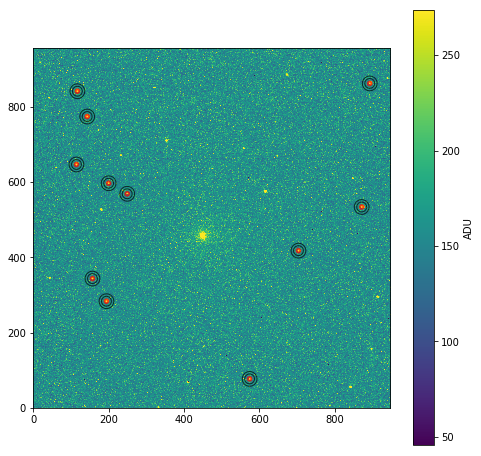

In [76]:
from photutils import CircularAperture as CircAp
from photutils import CircularAnnulus as CircAn

# H.3. Set parameters for the aperture photometry + make apertures and annuli
g = new_hdr['GAIN']
R = new_hdr['RONOISE']
r_ap = 1.5 * FWHM
n_ap = np.pi * r_ap**2
r_in = 4.0 * FWHM
r_out = 6.0 * FWHM

coo_matched = (UCAC4_matched['xcentroid'], UCAC4_matched['ycentroid'])
apertures_matched = CircAp(positions=coo_matched, r=r_ap)
annuli_matched = CircAn(positions=coo_matched, r_in=r_in, r_out=r_out)

# FYI, let me plot the apertures and annuli of matched stars (You may skip this):
fig, ax = plt.subplots(1,1, figsize=(8,8))
c = zimshow(ax, cut_hdu.data)
apertures_matched.plot(color='red', lw=2, alpha=0.7)
annuli_matched.plot(color='k', lw=1, alpha=0.7)
plt.colorbar(c, label="ADU")
plt.show()

In the above code, the determination of the aperture size (``r_ap``) and annulus region (``r_in`` and ``r_out``) are rather subjective. A rule of thumb is, 

* $r_{\rm ap} = 1.5 \times {\rm FWHM} \approx 3.5 \sigma_r$
* $r_{\rm in} = 4.0 \times {\rm FWHM} \approx 9.4 \sigma_r$
* $r_{\rm out} = 6.0 \times {\rm FWHM} \approx 14.1 \sigma_r$

Here, $\sigma_r$ is the standard deviation of a Gaussian curve if you fit Gaussian to the stellar radial profile. The detailed values can change if there are a lot of stars (crowded region), etc. In such cases, it is generally recommended to use PSF photometry.

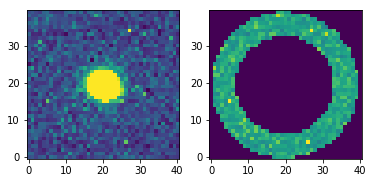

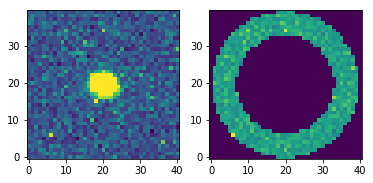

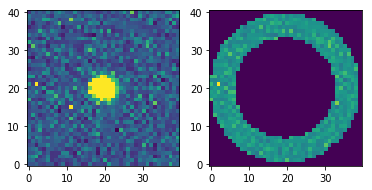

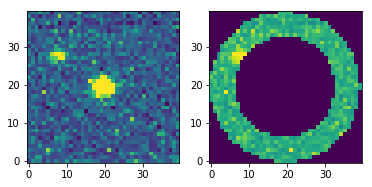

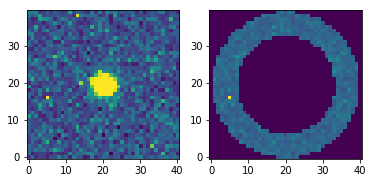

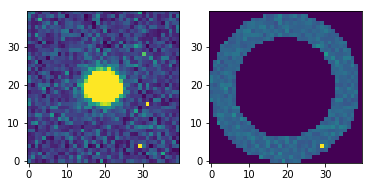

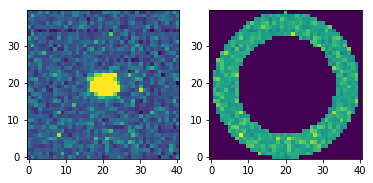

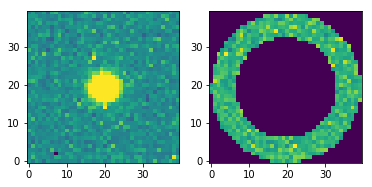

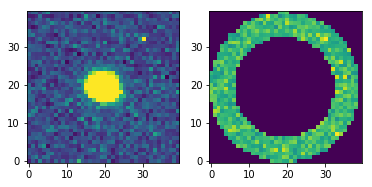

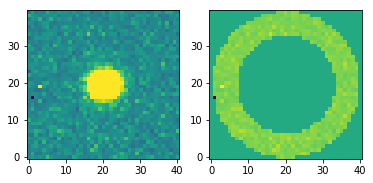

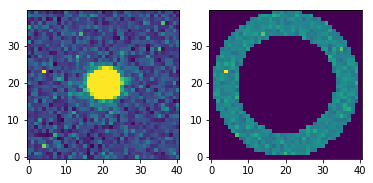

In [77]:
sky_values = annul2values(cut_hdu.data, annulus=annuli_matched)
skys = sky_fit(sky_values)

# FYI, let me plot the zoomed in annuli region (You may skip this):
for i, star in enumerate(UCAC4_matched):
    mask_annuli = annuli_matched.to_mask(method='center')[i]
    cutimg = mask_annuli.cutout(cut_hdu.data)
    
    # Plot for your information
    f, ax = plt.subplots(1, 2)
    zimshow(ax[0], cutimg)
    zimshow(ax[1], mask_annuli.multiply(cut_hdu.data))
    plt.show()

In [110]:
from photutils.utils import calc_total_error
from astropy.table import join

errormap = calc_total_error(data = cut_hdu.data, 
                            bkg_error = np.ones_like(cut_hdu.data) * R, 
                            effective_gain = g)
phot_f = apphot_annulus(cut_hdu.data, apertures_matched, annuli_matched,
                        t_exposure = cut_hdu.header['EXPTIME'],
                       error = errormap)
phot_f = hstack([Table(phot_f), Table(UCAC4_matched)])

``Table()`` is required since ``UCAC4_matched`` is ``Table`` and ``phot_f`` is ``QTable``. See [Quantity and QTable document](http://docs.astropy.org/en/stable/table/mixin_columns.html#quantity-and-qtable).

In [111]:
phot_f

id,xcenter,ycenter,aperture_sum,aperture_sum_err,msky,nrej,nsky,ssky,source_sum,mag,merr,RAJ2000,DEJ2000,Nu,gmag,e_gmag,x,y,xcentroid,ycentroid,peak,pixel_shift
,pix,pix,,,,,,,,,,deg,deg,,mag,cmag,,,,,,
int64,float64,float64,float64,float64,float64,int64,int64,float32,float64,float64,float64,float64,float64,int16,float32,bytes2,float64,float64,float64,float64,float64,float64
1,871.8255124791556,533.4237919871616,144776.0011326087,332.5124107191601,155.53594970703125,8,671,20.939894,132951.57573194493,-8.363855596348879,0.002761419679159372,143.6586836,17.5545753,3,13.655,09,872.2936218238069,533.3407,871.8255,533.4238,9482.3848,0.4754
2,703.9661714864419,417.53009431566187,41508.99962658023,191.83941031339185,156.35354614257812,7,673,20.966358,29622.417482872923,-6.7336731199553785,0.007383228214410154,143.6947765,17.5321067,3,15.244,10,703.9596758417456,417.5986,703.9662,417.5301,2220.3752,0.0688
3,574.306218734397,77.08188912769029,30516.88046574719,170.1494803491348,155.48243713378906,9,669,20.593824,18696.52329131338,-6.234024011267552,0.010487467280698869,143.7238306,17.4641459,3,15.702,08,574.0979075414839,76.4898,574.3062,77.0819,1464.5144,0.6276
4,249.34328899586387,568.4588866022008,20674.365054430145,148.05565680560758,155.2898941040039,6,671,21.103703,8868.645722221241,-5.42426514000385,0.019647682919864157,143.7900368,17.5645934,3,16.400,01,249.1819616258054,568.6230,249.3433,568.4589,859.6160,0.2301
5,200.12859150588767,596.4451819083692,29774.56337824304,168.58416050153176,156.35906982421875,11,671,20.244154,17887.561303570452,-6.185999711960717,0.010849578204329944,143.8001836,17.5703467,3,15.731,12,200.49346240150612,596.1232,200.1286,596.4452,1556.6492,0.4867
6,194.27311502034416,283.2915801770139,149840.13432409987,337.90788874512776,155.4027862548828,8,669,20.838264,138025.83250778422,-8.404522812248135,0.0027013565578227136,143.8029533,17.5074225,6,13.647,09,194.40919731656885,282.9755,194.2731,283.2916,10933.5996,0.3441
7,157.1633473451278,343.3239461980625,32783.199505066004,174.84177125870053,156.21131134033203,11,664,20.344263,20907.43058371472,-6.355373532856977,0.009599758764552936,143.8105271,17.5196806,3,15.599,10,157.1686502428867,343.0982,157.1633,343.3239,1770.2944,0.2258
8,114.61115750684881,646.2712095667682,84226.35555321086,259.45087481032004,155.49445343017578,10,664,20.667484,72405.08485492301,-7.704044541152873,0.003996542992634234,143.8179633,17.5808428,4,14.317,11,115.14017061562339,646.3794,114.6112,646.2712,6026.6382,0.5400


* **HOMEWORK**: Run ``plt.errorbar(phot_f["id"], phot_f["msky"], yerr=phot_f["ssky"])`` and see how robust the sky estimation is. In this small FOV, sky seems to be almost constant over the frame.

* **NOTE**: The ``merr`` is very small compared to the catalog error, as you can see. This is because the error from our calculation is just a nominal "statistical" error, which does not include the possible uncertainties from the imperfect method, CCD defects, etc. If we observe the same star over and over again, the measurements will give, for example, $ 14.0 \pm 0.003$, $14.1 \pm 0.002$, .... After such observations, the sample standard deviations (which is the ``e_gmag`` from UCAC4) will be much larger than such statistical errors. See our lecture note about statistics.

## 6.1. Instrumental VS Catalog Magnitude

Although we have already obtained the instrumental magnitude for each star, we can go further to investigate the relation between the instrumental and catalog magnitude. Since catalog magnitude is a real magnitude and our instrumental magnitude is kind of a proxy to that real magnitude, a relationship between these two ($m_{\rm real} = a m_{\rm inst} + b$) will give us a mapping from instrumental to real magnitude, and vice versa. This is important for relative photometry. In our case, we will be able to calculate $m_{\rm inst}$ of comet for any image, and using field stars, $a$ and $b$ are calculable in that image. Then we can convert the instrumental magnitude of the comet to real magnitude, and thus we are able to see the magnitude variation of the comet over time.

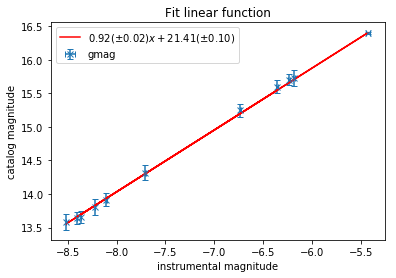

In [154]:
from scipy.optimize import curve_fit

def lin_func(x, a=1, b=0):
    return a * x + b

# Rough total error in magnitude
err_catalog = (np.array(phot_f[f'e_{obs_filter}mag']).astype(int)/100)
err_phot = phot_f['merr']
err = np.sqrt(err_phot**2 + err_catalog**2)

# Curve fit
popt, pcov = curve_fit(lin_func, phot_f['mag'], phot_f[f'{obs_filter}mag'], sigma=err, absolute_sigma=True)

a0, b0 = popt
da, db = np.sqrt(np.diag(pcov))

# plot
plt.errorbar(phot_f['mag'], phot_f['gmag'], yerr = err_catalog, xerr=err_phot, capsize=3, marker='x', ls='')
plt.plot(phot_f['mag'], lin_func(phot_f['mag'], *popt), 'r-', 
         label=r"${:.2f}(\pm {:.2f}) x + {:.2f} (\pm {:.2f})$".format(a0, da, b0, db))
plt.xlabel("instrumental magnitude")
plt.ylabel("catalog magnitude")
plt.title("Fit linear function")
plt.legend()

``np.array(phot_f[f'e_{obs_filter}mag']).astype(int)**2`` is required since ``UCAC4`` catalog gives magnitude in unit of cmag... I couldn't find a simpler approach yet.

See [scipy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) for ``curve_fit``.

Another approach to this fitting is that fixing slope as 1, i.e., you strongly believe the linearity of the CCD.
Then

21.881232229018558 0.018117689937037787


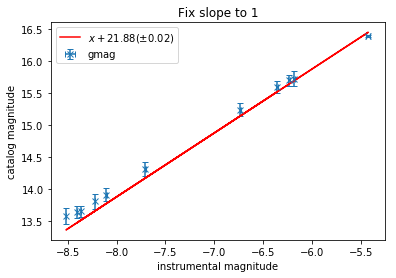

In [153]:
from scipy.optimize import curve_fit

def lin_func_1(x, b=0):
    return x + b

popt, pcov = curve_fit(lin_func_1, phot_f['mag'], phot_f[f'{obs_filter}mag'], sigma=err, absolute_sigma=True)
b0 = popt[0]
db = np.sqrt(pcov[0,0])

print(b0, db)
plt.errorbar(phot_f['mag'], phot_f['gmag'], yerr = err_catalog, xerr=err_phot, capsize=3, marker='x', ls='')
plt.plot(phot_f['mag'], lin_func_1(phot_f['mag'], b0), 'r-', 
         label=r"$x + {:.2f} (\pm {:.2f})$".format(b0, db))
plt.xlabel("instrumental magnitude")
plt.ylabel("catalog magnitude")
plt.title("Fix slope to 1")
plt.legend()

In this case, as you can see, the fitting seems worse. Plus, the zero point (intercept) got larger by 0.4 magnitude. It depends on your subjective opinion whether to choose this or the former.